In [29]:
%load_ext autoreload
%autoreload 2


# Auto Encoder for Dimensionality Reduction

In [ ]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import CancerDataAutoEncoder

In [3]:
np.random.seed(42)

# Parameters
num_samples = 2621
num_genes = 1800

# Base clinical data
clinical_data = {
    "PatientID": [f"PID_{i}" for i in range(1, num_samples + 1)],
    "CopyNumberVariant": np.random.randint(0, 10, size=num_samples),
    "SmokingStatus": np.random.choice([1, 0], size=num_samples),
    "OverallSurvivalMonths": np.random.uniform(6, 60, size=num_samples).round(2),
}

# Simulated gene mutation matrix: binary (0=wildtype, 1=mutated)
mutation_matrix = np.random.choice([0, 1], size=(num_samples, num_genes), p=[0.97, 0.03])

# Gene column names
gene_cols = [f"Gene_{i+1}" for i in range(num_genes)]
mutation_df = pd.DataFrame(mutation_matrix, columns=gene_cols, index=clinical_data["PatientID"])

# Combine all data
cancer_df = pd.concat([pd.DataFrame(clinical_data).set_index("PatientID"), mutation_df], axis=1)

# Preview
print(cancer_df.iloc[:, :10].head())  # Just print first 10 columns to avoid overload


       CopyNumberVariant  SmokingStatus  OverallSurvivalMonths  Gene_1  \
PID_1                  6              1                  30.92       0   
PID_2                  3              1                  59.10       0   
PID_3                  7              0                  48.48       0   
PID_4                  4              0                  47.78       0   
PID_5                  6              1                  46.38       0   

       Gene_2  Gene_3  Gene_4  Gene_5  Gene_6  Gene_7  
PID_1       0       0       0       0       0       0  
PID_2       0       0       0       0       0       0  
PID_3       0       0       0       0       0       0  
PID_4       0       0       0       1       0       0  
PID_5       0       0       0       0       0       0  


In [31]:
cancer_ds = CancerDataset(cancer_df)
cancer_ds[0]

(tensor([ 6.0000,  1.0000, 30.9200,  ...,  0.0000,  0.0000,  0.0000]),
 tensor([0.]))

In [32]:
cancer_dm = CancerDataModule(cancer_ds)
cancer_dm.setup()

In [33]:
len(cancer_dm.ds_train), len(cancer_dm.ds_val), len(cancer_dm.ds_test)

(1573, 524, 524)

In [9]:
first_item = cancer_dm.ds_train[0]
data, label = first_item
print(f"Data: {data}")
print(f"Label: {label}")

Data: tensor([ 6.0000,  0.0000, 54.1500,  ...,  0.0000,  0.0000,  0.0000])
Label: tensor([0.])


In [11]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(CancerDataAutoEncoder(input_size=input_dim, latent_size=20), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
CancerDataAutoEncoder                    [1, 1802]                 --
├─Sequential: 1-1                        [1, 20]                   --
│    └─Linear: 2-1                       [1, 1208]                 2,178,024
│    └─ReLU: 2-2                         [1, 1208]                 --
│    └─Dropout: 2-3                      [1, 1208]                 --
│    └─Linear: 2-4                       [1, 614]                  742,326
│    └─ReLU: 2-5                         [1, 614]                  --
│    └─Dropout: 2-6                      [1, 614]                  --
│    └─Linear: 2-7                       [1, 20]                   12,300
│    └─ReLU: 2-8                         [1, 20]                   --
│    └─Dropout: 2-9                      [1, 20]                   --
├─Sequential: 1-2                        [1, 1802]                 --
│    └─Linear: 2-10                      [1, 614]                  12

In [ ]:
from utils.helper_functions import create_classifier_trainer


trainer, ae_csv_logger, ae_checkpoint = create_classifier_trainer("cancer_auto_encoder")
cancer_ae = CancerDataAutoEncoder(input_size=len(cancer_dm.ds_train[0][0]), latent_size=20, n_layers=3, dropout=0.2)
trainer.fit(
    cancer_ae,
    datamodule=CancerDataModule(cancer_ds),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 2.9 M  | train
1 | decoder     | Sequential       | 2.9 M  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
---------------------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.468   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jacobtye/mambaforge/envs/bmi_6114/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/jacobtye/mambaforge/envs/bmi_6114/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

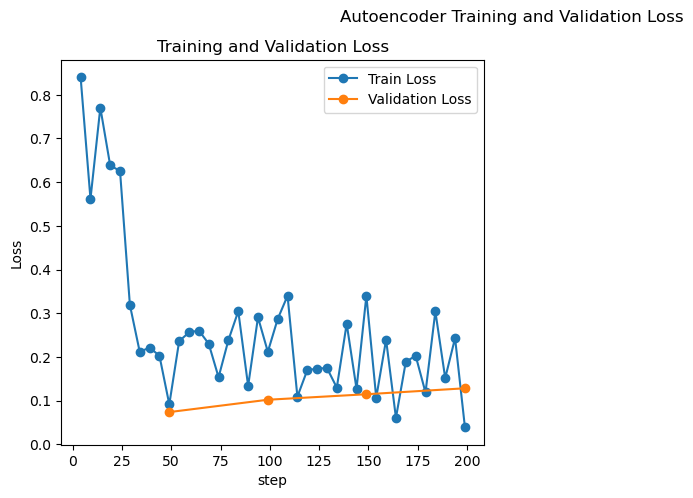

In [13]:
history = pd.read_csv(ae_csv_logger.log_dir + "/metrics.csv")
def make_plots(history, title):
    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    train_history = history.dropna(subset=["train_loss"])
    val_history = history.dropna(subset=["val_loss"])
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_history["step"], train_history["train_loss"], label="Train Loss", marker="o")
    plt.plot(
        val_history["step"],
        val_history["val_loss"],
        label="Validation Loss",
        marker="o",
        linestyle="-",
    )
    plt.xlabel("step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()



make_plots(history, "Autoencoder Training and Validation Loss")

In [ ]:
import optuna

trial_to_details = {}
def objective(trial):
    latent_size = trial.suggest_int("latent_size", 8, 256)
    n_layers = trial.suggest_int("n_layers", 1, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    input_dim = len(cancer_dm.ds_train[0][0])

    model = CancerDataAutoEncoder(
        input_size=input_dim,
        latent_size=latent_size,
        n_layers=n_layers,
        dropout=dropout,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", enable_pbar=false)


    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    trainer.fit(model, datamodule=cancer_dm)

    # Load validation metrics from CSV logger
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse_epoch" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse_epoch"].dropna().values[-1]
    return last_val

# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="autoencoder_study")
study.optimize(objective, n_trials=5)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-11 14:18:39,657] A new study created in memory with name: autoencoder_study
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 313 K  | train
1 | decoder     | Sequential       | 315 K  | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
---------------------------------------------------------
629 K     Trainable params
0         Non-trainable params
629 K     Total params
2.516     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/jacobtye/mambaforge/envs/bmi_6114/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which ma

Best trial:
  Value (val_mse): 0.0457669831812381
  Params:
    latent_size: 129
    n_layers: 5
    dropout: 0.04892076156671582


In [15]:
trial_to_details[study.best_trial.number]["checkpoint"].best_model_path

'optuna_logs/trial_2/version_2/checkpoints/best_ae_trial_2.ckpt'

In [16]:
best_model_path = trial_to_details[study.best_trial.number]["checkpoint"].best_model_path
with open("results/02/results.txt", "w") as f:
    f.write(best_model_path)

In [20]:
import json

with open("results/02/best_trial_params.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=4)

In [17]:
CancerDataAutoEncoder.load_from_checkpoint(
    trial_to_details[study.best_trial.number]["checkpoint"].best_model_path,
    **study.best_trial.params
)

CancerDataAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=1802, out_features=1468, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04892076156671582, inplace=False)
    (3): Linear(in_features=1468, out_features=1134, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04892076156671582, inplace=False)
    (6): Linear(in_features=1134, out_features=800, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04892076156671582, inplace=False)
    (9): Linear(in_features=800, out_features=466, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04892076156671582, inplace=False)
    (12): Linear(in_features=466, out_features=132, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.04892076156671582, inplace=False)
    (15): Linear(in_features=132, out_features=129, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=129, out_features=463, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04892076156671582, inplace=False)
    (3): Linear(in_features=463, out_features=797, b

In [18]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

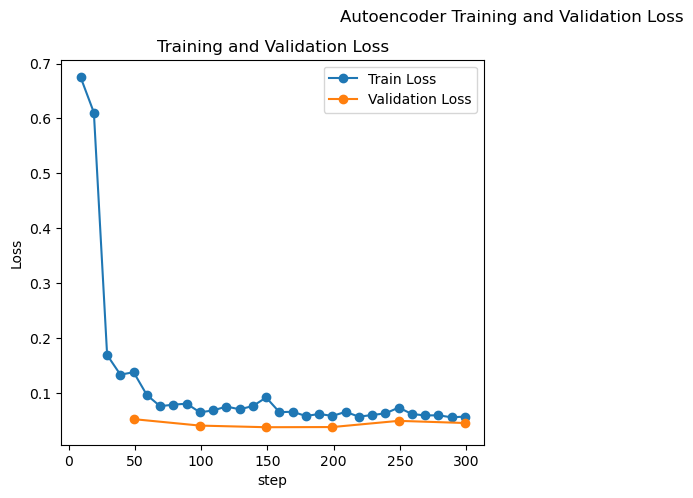

In [19]:
history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")

make_plots(history, "Autoencoder Training and Validation Loss")